In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from helpers import sql

In [2]:
all_steps = [
    'submission_date',
    'date_chair_sent',
    'date_chair_appr',
    'date_coordinator_sent',
    'date_coordinator_appr',
    'date_section_head_sent',
    'date_section_head_appr',
    'date_division_manager_sent',
    'date_division_manager_appr',
    'date_director_sent',
    'date_director_appr',
    'date_translation_sent',
    'date_returned',
    'translation_review_date',
    'date_doc_submitted',
    'date_proof_author_sent',
    'date_proof_author_approved',
    'actual_posting_date',
]

gantt_steps = [
    'submission_date',
    'date_chair_appr',
    'date_director_appr',
    'date_translation_sent',
    'date_returned',
    'date_doc_submitted',
    'actual_posting_date',
]

document_types = {
    2: "SAR",  # 56 days due
    3: "RES",  # 122 days due
    4: "PRO",  # 122 days due
    5: "SRR",  # 56 days due
    6: "working_paper",
    8: "translation_only",
}

In [3]:
tracking = sql("SELECT * FROM csas2_documenttracking JOIN csas2_document ON csas2_document.id = document_id")

tracking['document_type'] = tracking['document_type_id'].map(document_types)
tracking = tracking[tracking['status'] != 99]

sar_tracking = tracking[tracking.document_type != "SAR"].copy()
res_tracking = tracking[tracking.document_type != "RES"].copy()
pro_tracking = tracking[tracking.document_type != "PRO"].copy()
srr_tracking = tracking[tracking.document_type != "SRR"].copy()

all_doctypes = [
    ["RES", res_tracking, 122],
    ["SAR", sar_tracking, 56],
    ["PRO", pro_tracking, 122],
    ["SRR", srr_tracking, 56],
]

In [4]:
def time_matrix(dataframe, col_lst, all_stats=False, quantile=0.5):
    df_temp = dataframe[col_lst].apply(pd.to_datetime, errors='coerce')
    matrix = pd.DataFrame(index=col_lst, columns=col_lst)
    
    for i, from_step in enumerate(col_lst):
        for j, to_step in enumerate(col_lst):
            if i < j:
                if all_stats:
                    matrix.loc[from_step, to_step] = (
                        round((df_temp[to_step] - df_temp[from_step]).dt.days.mean(), 1),
                        round((df_temp[to_step] - df_temp[from_step]).dt.days.quantile([0.025, 0.16, 0.5, 0.84, 0.975]), 1),
                    )
                else:
                    matrix.loc[from_step, to_step] = round((df_temp[to_step] - df_temp[from_step]).dt.days.quantile(quantile), 1)
                
    return matrix.apply(pd.to_numeric, errors='coerce').dropna(how='all').dropna(how='all', axis=1)


def plot_heatmap(dataframe, col_lst, quantile=0.5, figsize=(4, 4)):
    plt.figure(figsize=figsize)
    
    matrix = time_matrix(dataframe, col_lst, quantile=quantile).fillna(-99)
    annot = matrix.map(lambda x: f"{int(x)}" if x >= 0 else "")
    
    fig = sns.heatmap(
        matrix, 
        annot=annot, 
        cmap='Blues',
        vmin=-10,
        vmax=100,
        fmt='', 
        cbar=False
    )
    
    fig.xaxis.set_ticks_position('top')
    fig.tick_params(axis='x', rotation=90, length=0)
    fig.tick_params(axis='x', rotation=90)
    
    plt.show()
    

def plot_all_heatmaps(dataframe, quantile=0.5, steps=None, figsize=(4, 4)):
    if steps:
        plot_heatmap(dataframe, steps, quantile=quantile, figsize=figsize)
    else:
        plot_heatmap(dataframe, all_steps, quantile=quantile, figsize=figsize)


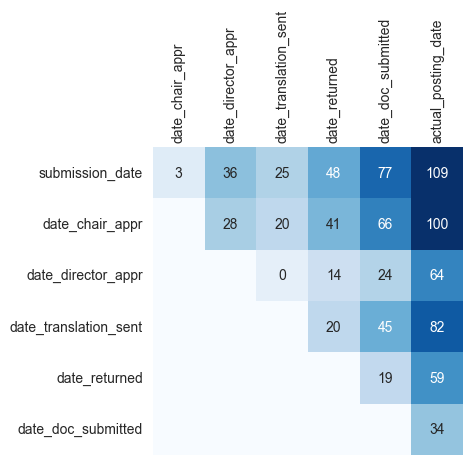

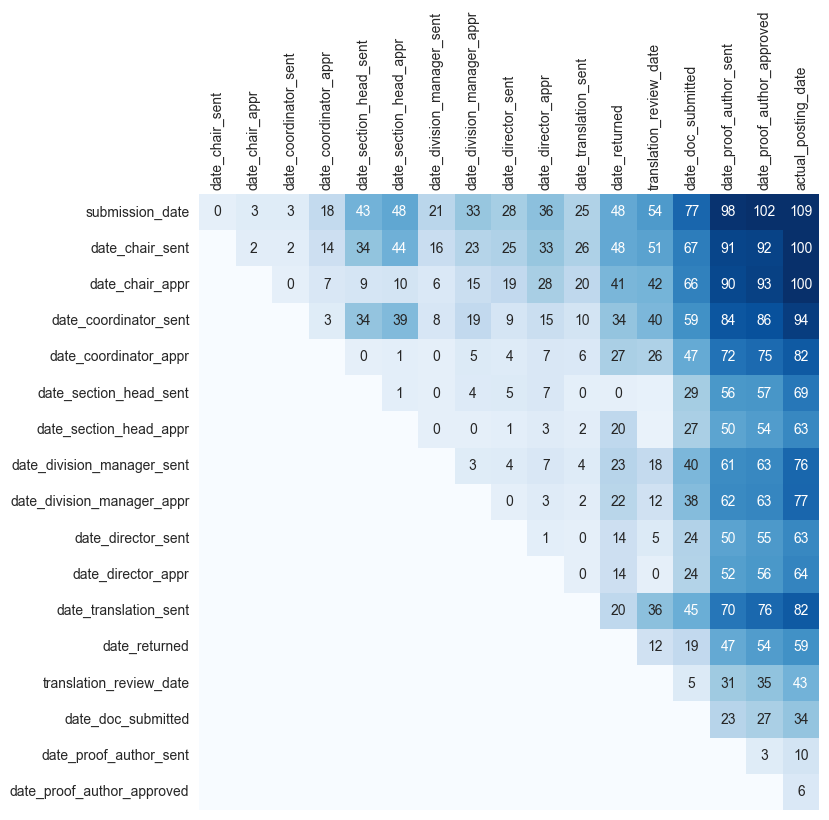

In [5]:
plot_all_heatmaps(tracking, steps=gantt_steps)
plot_all_heatmaps(tracking, steps=all_steps, figsize=(8, 8))



QUANTILE: 50%


RES - due in 122 days


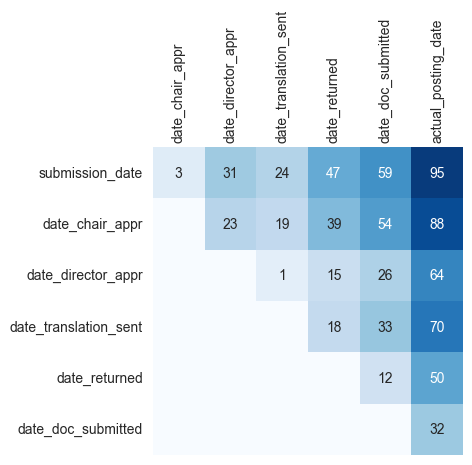


SAR - due in 56 days


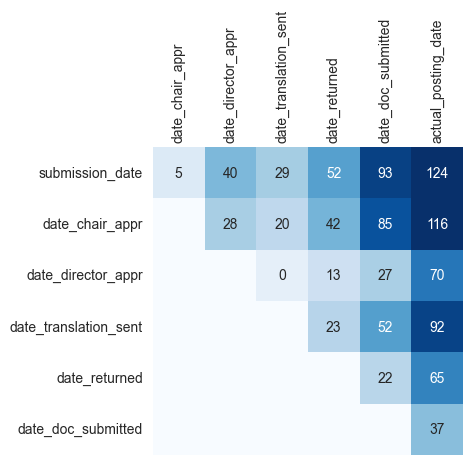


PRO - due in 122 days


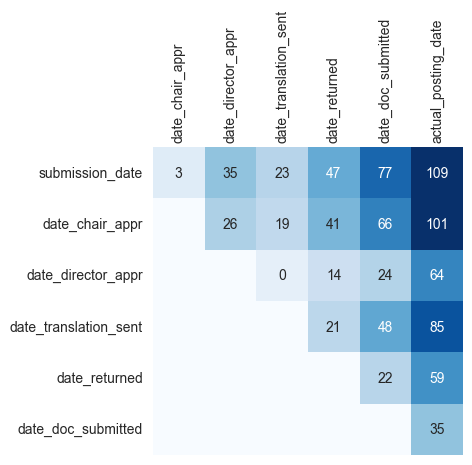


SRR - due in 56 days


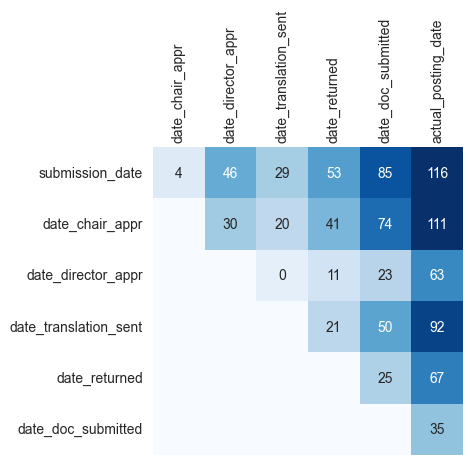



QUANTILE: 16%


RES - due in 122 days


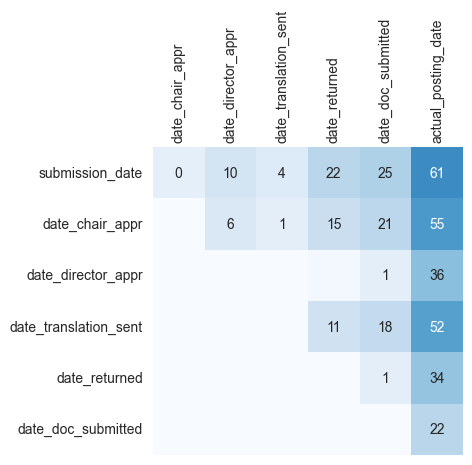


SAR - due in 56 days


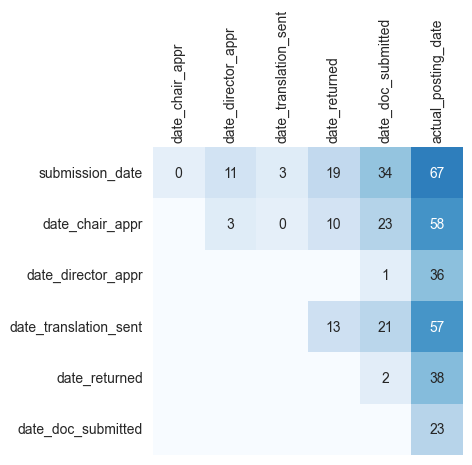


PRO - due in 122 days


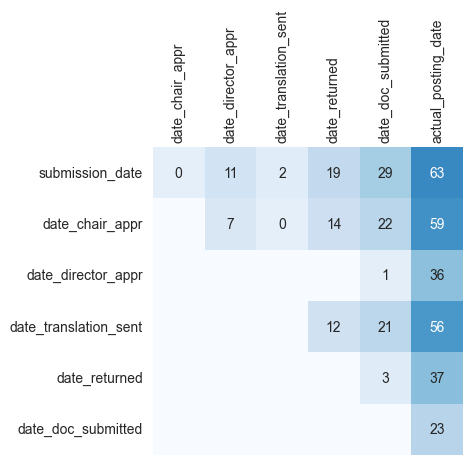


SRR - due in 56 days


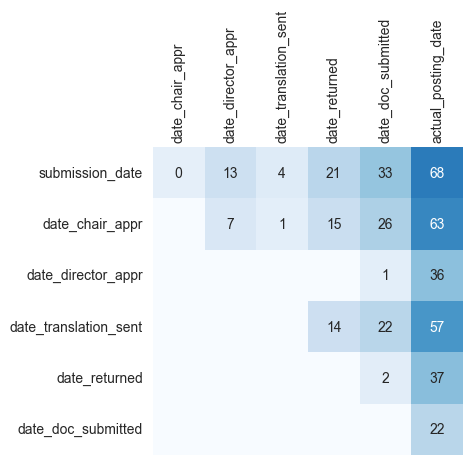



QUANTILE: 84%


RES - due in 122 days


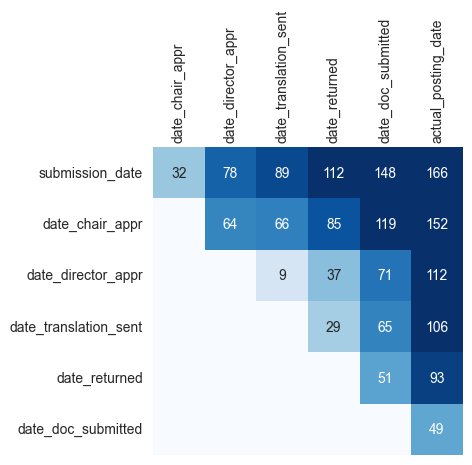


SAR - due in 56 days


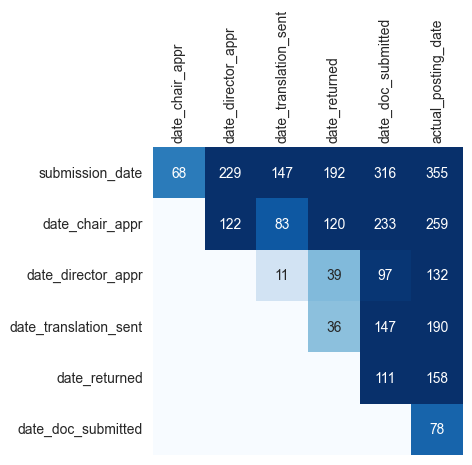


PRO - due in 122 days


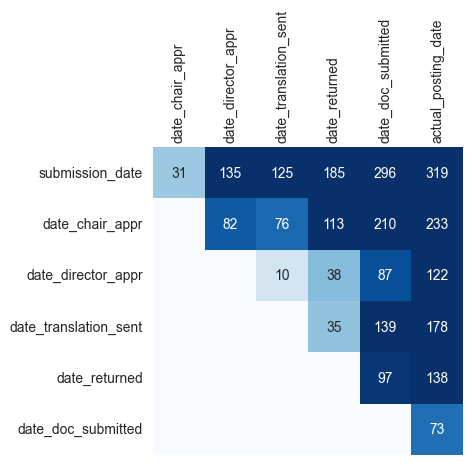


SRR - due in 56 days


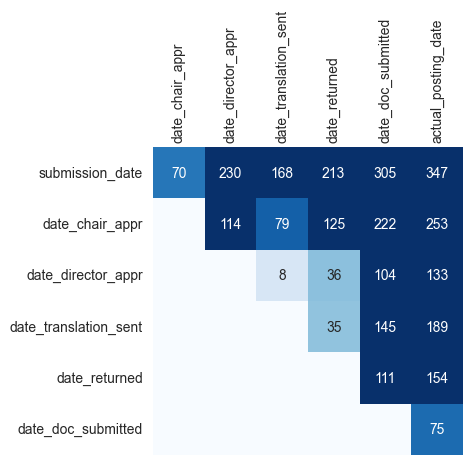

In [8]:
for q in [0.5, 0.16, 0.84]:
    print(f"\n\n==========================\nQUANTILE: {q:.0%}\n==========================\n")
    for name, df, n in all_doctypes:
        print(f'\n{name} - due in {n} days')
        plot_all_heatmaps(df, quantile=q, steps=gantt_steps)